# Student Score analytics

## Data Load

Load in the data and check that is loads in correctly

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from DataLoading import load_data
from FeatureEngineering import one_hot_encode_feature
import sklearn
import numpy as np

In [2]:
student_df = load_data()

In [3]:
student_df.shape

(1000, 8)

Data shape matches the shape on the dataset specs

In [4]:
student_df.columns

Index(['gender', 'race_ethnicity', 'parental_level_of_education', 'lunch',
       'test_preparation_course', 'math_score', 'reading_score',
       'writing_score'],
      dtype='object')

Columns match the columns on the specs

## EDA (Exploratory Data Analysis)

### Missing Data

In [5]:
student_df.isnull().sum()

gender                         0
race_ethnicity                 0
parental_level_of_education    0
lunch                          0
test_preparation_course        0
math_score                     0
reading_score                  0
writing_score                  0
dtype: int64

Well that's a welcome change. No missing data

### Basic feel

In [6]:
student_df.head(8)

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75
5,female,group B,associate's degree,standard,none,71,83,78
6,female,group B,some college,standard,completed,88,95,92
7,male,group B,some college,free/reduced,none,40,43,39


### Variable analysis

#### gender

##### Value types

In [7]:
type(student_df.gender[0])

str

String values, how many?

##### distribution

In [8]:
student_df.gender.value_counts()

gender
female    518
male      482
Name: count, dtype: int64

two types, reasonably evenly split as well

<Axes: >

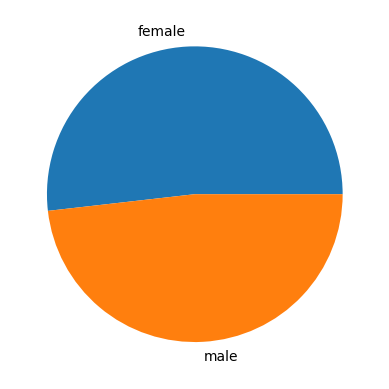

In [9]:
student_df.groupby('gender').size().plot(kind='pie')

#### race_ethnicity

This is an ethical landmine. Do the smart thing and delete this feature completely

In [10]:
all_cols = student_df.columns.to_list()
all_cols.remove('race_ethnicity')
student_df = student_df[all_cols]

#### parental_level_of_education

In [11]:
all_cols[1]

'parental_level_of_education'

In [12]:
feature_of_interest = all_cols[1]
feature_of_interest

'parental_level_of_education'

In [13]:
VC = student_df[feature_of_interest].value_counts()
VC

parental_level_of_education
some college          226
associate's degree    222
high school           196
some high school      179
bachelor's degree     118
master's degree        59
Name: count, dtype: int64

In [14]:
list(VC.index)

['some college',
 "associate's degree",
 'high school',
 'some high school',
 "bachelor's degree",
 "master's degree"]

Text(0.5, 1.0, 'distribution of educational level')

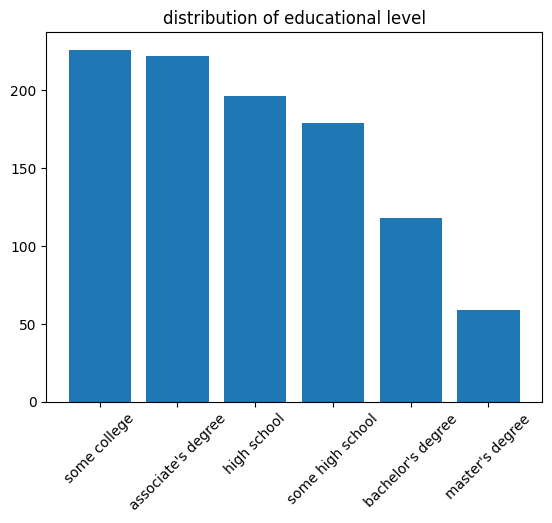

In [15]:
_ = plt.bar(range(6),student_df[feature_of_interest].value_counts())
_ = plt.xticks(range(6),list(VC.index), rotation=45)
plt.title ('distribution of educational level')

Doesn't look like the ordering is correct, should reorder in ascending level of education

In [16]:
education_dict= {'some high school': 0,
                 'high school': 1,
                 "associate's degree": 2,
                 'some college': 3,
                 "bachelor's degree": 4,
                 "master's degree": 5}
                 

Ugh, painful use of single quotation marks as apostrophes in the data

In [17]:
from FeatureEngineering import ordinal_encode_feature

In [18]:
student_df = ordinal_encode_feature(student_df, feature_of_interest, education_dict)

In [19]:
student_df.head(5)

,gender,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score
0,female,4,standard,none,72,72,74
1,female,3,standard,completed,69,90,88
2,female,5,standard,none,90,95,93
3,male,2,free/reduced,none,47,57,44
4,male,3,standard,none,76,78,75


In [20]:
reverse_edu_dict = {val: key for key, val in education_dict.items()}

In [21]:
student_df[feature_of_interest]

0      4
1      3
2      5
3      2
4      3
      ..
995    5
996    1
997    1
998    3
999    3
Name: parental_level_of_education, Length: 1000, dtype: int64

Text(0.5, 1.0, 'distribution of educational level')

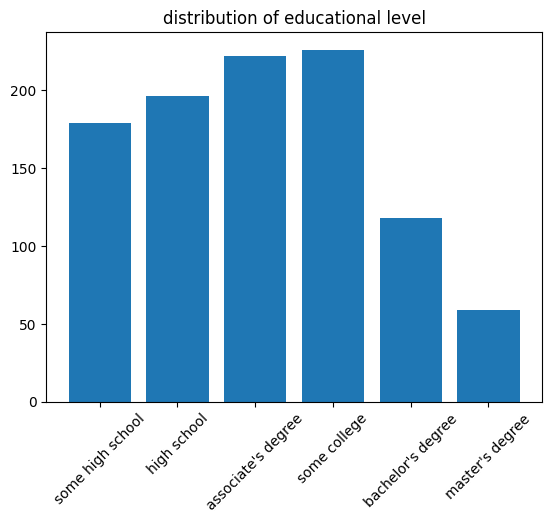

In [22]:
VCi = student_df[feature_of_interest].value_counts().sort_index()
XTix = [reverse_edu_dict[key] for key in VCi.index]
_ = plt.bar(range(6),VCi.values)
_ = plt.xticks(range(6),XTix, rotation=45)
plt.title ('distribution of educational level')

ok, that looks more understandable. Surprising, but interesting

#### lunch

In [23]:
feature_of_interest = student_df.columns[2]
feature_of_interest

'lunch'

In [24]:
student_df[feature_of_interest].value_counts()

lunch
standard        645
free/reduced    355
Name: count, dtype: int64

Not exactly balanced, but sizeable enough to work with. Any modelling will need to account for the imbalance

<Axes: >

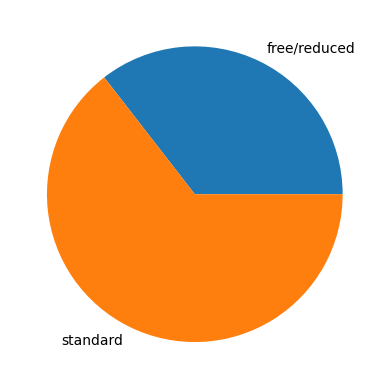

In [25]:
student_df.groupby('lunch').size().plot(kind='pie')

#### Test preperation course

In [27]:
feature_of_interest = student_df.columns[3]
feature_of_interest

'test_preparation_course'

In [28]:
student_df[feature_of_interest].value_counts()

test_preparation_course
none         642
completed    358
Name: count, dtype: int64

I'm curious as to the bayesian inference of this one on the test scores.

In [29]:
passfail = lambda x: 'pass' if x >= 50 else 'fail'

In [30]:
bayesian_df = student_df.copy()
bayesian_df['math_passed'] = bayesian_df['math_score'].apply(passfail)
bayesian_df['reading_passed'] = bayesian_df['reading_score'].apply(passfail)
bayesian_df['writing_passed'] = bayesian_df['writing_score'].apply(passfail)
bayesian_df[['math_score','math_passed','reading_score','reading_passed','writing_score','writing_passed']].head(10)

,math_score,math_passed,reading_score,reading_passed,writing_score,writing_passed
0,72,pass,72,pass,74,pass
1,69,pass,90,pass,88,pass
2,90,pass,95,pass,93,pass
3,47,fail,57,pass,44,fail
4,76,pass,78,pass,75,pass
5,71,pass,83,pass,78,pass
6,88,pass,95,pass,92,pass
7,40,fail,43,fail,39,fail
8,64,pass,64,pass,67,pass
9,38,fail,60,pass,50,pass


OK, that's working

In [31]:
def pass_perc (df_in: pd.DataFrame, feature: str) -> float:
    
    result_col = feature + '_passed'    
    total_scores = df_in.shape[0]    
    passed = df_in[df_in[result_col] == 'pass'].shape[0]    
    failed = total_scores - passed
    
    return passed / total_scores

In [32]:
score_cols = ['reading', 'writing', 'math']
base_pass_rates = {col: pass_perc(bayesian_df, col) for col in score_cols}
for key, val in base_pass_rates.items():
    print (f"{key}: {100*val:.2f}%")

reading: 91.00%
writing: 88.60%
math: 86.50%


let's one-hot encode this one

##### pass percentage with prep course

In [36]:
feature_of_interest

'test_preparation_course'

In [37]:
bayesian_df[feature_of_interest]

0           none
1      completed
2           none
3           none
4           none
         ...    
995    completed
996         none
997    completed
998    completed
999         none
Name: test_preparation_course, Length: 1000, dtype: object

In [38]:
prepped_df = bayesian_df[bayesian_df[feature_of_interest] == 'completed']

In [40]:
prep_pass_rates = {col: pass_perc(prepped_df, col) for col in score_cols}
for key, val in prep_pass_rates.items():
    print (f"{key}: {100*val:.2f}%")

reading: 95.53%
writing: 95.53%
math: 92.18%


Text(0, 0.5, 'Percentage pass rate')

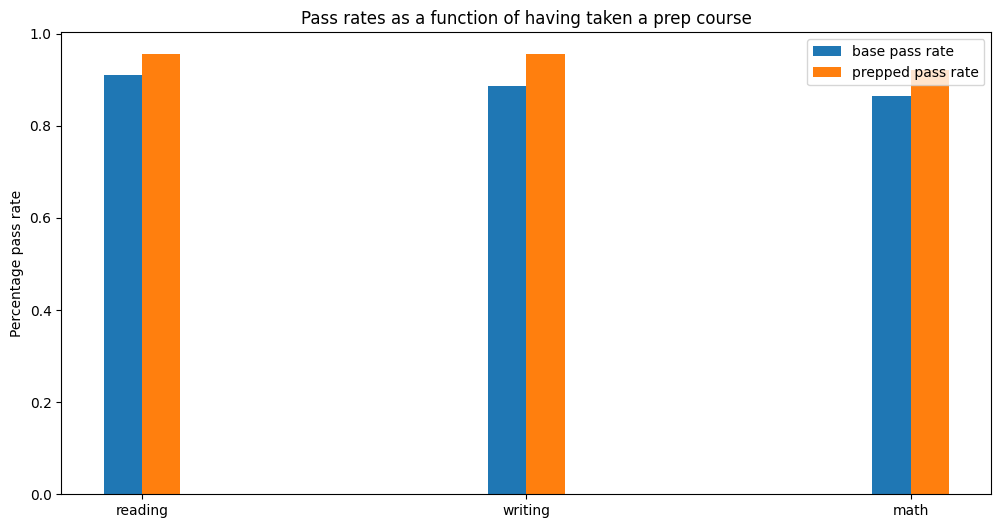

In [42]:
plt.rcParams['figure.figsize'] = (12,6)
X = np.array([1, 2, 3])
Width = 0.1
# plt.bar(X, np.array(list(base_pass_rates.values()))-0.1)
plt.bar (X-Width/2, list(base_pass_rates.values()), width=Width, label = 'base pass rate')
plt.bar (X+Width/2, list(prep_pass_rates.values()), width=Width, label = 'prepped pass rate')
plt.xticks (X, base_pass_rates.keys())
plt.legend()
plt.title ('Pass rates as a function of having taken a prep course')
plt.ylabel ('Percentage pass rate')
         

Definitely makes a difference, should be validated in the counterfactual

##### pass percentage without test prep course

In [43]:
un_prepped_df = bayesian_df[bayesian_df[feature_of_interest] == 'none'].copy()

In [44]:
un_prep_pass_rates = {col: pass_perc(un_prepped_df, col) for col in score_cols}
for key, val in un_prep_pass_rates.items():
    print (f"{key}: {100*val:.2f}%")

reading: 88.47%
writing: 84.74%
math: 83.33%


Text(0, 0.5, 'Percentage pass rate')

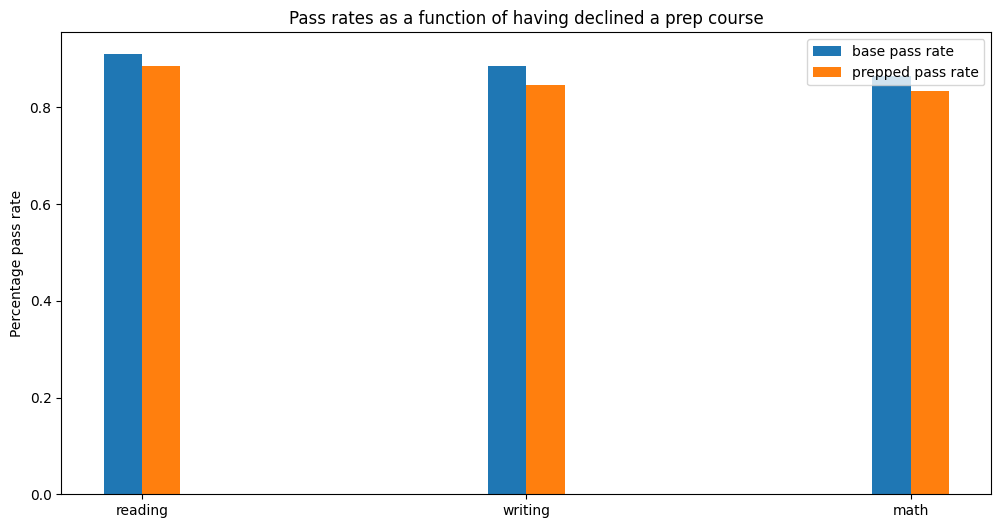

In [177]:
X = np.array([1, 2, 3])
Width = 0.1
# plt.bar(X, np.array(list(base_pass_rates.values()))-0.1)
plt.bar (X-Width/2, list(base_pass_rates.values()), width=Width, label = 'base pass rate')
plt.bar (X+Width/2, list(un_prep_pass_rates.values()), width=Width, label = 'prepped pass rate')
plt.xticks (X, base_pass_rates.keys())
plt.legend()
plt.title ('Pass rates as a function of having declined a prep course')
plt.ylabel ('Percentage pass rate')

Verified! <br> <br>
Conclusion is that there should be some predictive power in the data

In [179]:
student_df.columns

Index(['gender', 'parental_level_of_education', 'lunch', 'math_score',
       'reading_score', 'writing_score', 'test_preparation_course_completed',
       'test_preparation_course_none'],
      dtype='object')

In [178]:
student_df.groupby('test_preparation_course').size().plot(kind='pie')

KeyError: 'test_preparation_course'

In [ ]:
student_df = one_hot_encode_feature(student_df, feature_of_interest)
student_df.head()

#### Math Score

In [ ]:
feature_of_interest = student_df.columns[3]
feature_of_interest

In [ ]:
student_df[feature_of_interest].describe()

In [ ]:
student_df[feature_of_interest].hist(bins=20)
plt.title('Math Score distribution')

Nothing worrying about this distribution

#### Reading Score

In [ ]:
feature_of_interest = student_df.columns[4]
feature_of_interest

In [ ]:
student_df[feature_of_interest].describe()

In [ ]:
student_df[feature_of_interest].hist(bins=20)
plt.title ('Reading Score distribution')

Interesting. longer left-hand tail on reading, honestly quite surprising

#### Writing Score

In [ ]:
feature_of_interest = student_df.columns[5]
feature_of_interest

In [ ]:
student_df[feature_of_interest].describe()

In [ ]:
student_df[feature_of_interest].hist(bins=20)
plt.title('Writing Score')

Similar distribution to reading, as would be expected. Also showing the same long left-hand tail

No outliers in any of the numerical scores, no data cleaning to be done.

## Feature Engineering

We are looking to predict each of the three scores to see if there's any useful predictive power. 

In [ ]:
student_df.head()

### one-hot encode gender

Gender has no ordinal properties, and so should be one-hot-encoded

In [ ]:
from FeatureEngineering import one_hot_encode_feature

In [ ]:
df_gend = one_hot_encode_feature(student_df, 'gender')
df_gend.head()

### Ordinal encode lunch

There is clearly a 'better' version of this, so encode in an ordinal fashion, similar to how we've managed<br>
the parental level of education

In [ ]:
lunch_values = df_gend.lunch.unique()
lunch_values

In [ ]:
lunch_dict = {lunch_values[1]: 0,
              lunch_values[0]: 1}
lunch_dict

In [ ]:
df_lunch = ordinal_encode_feature(df_gend, 'lunch', lunch_dict)
df_lunch.head()

### Reorder to keep the target variable(s) on the right

In [ ]:
from FeatureEngineering import move_features_to_end

In [ ]:
target_features = ['math_score', 'reading_score', 'writing_score']
df_reshaped = move_features_to_end(df_lunch, target_features)
df_reshaped.head()

Excellent, time for the data processing

## Data Processing

### extract numpy array

In [ ]:
from DataProcessing import extract_data

In [ ]:
FA = extract_data(df_reshaped)

### scale data

Data needs to be scaled, lets do it

In [ ]:
from DataProcessing import scale_data, split_data, create_input_target

In [ ]:
scaled_data, scaler = scale_data(FA)

### Separate into training, validation and testing

In [ ]:
train_data, val_data, test_data = split_data(scaled_data)

In [ ]:
for dat in (train_data, test_data, val_data):
    print(dat.shape)

### create training and target matrices / vectors

default target is the last column, so this is training for writing score

In [ ]:
train_x, train_y = create_input_target(train_data)
val_x, val_y = create_input_target(val_data)
test_x, test_y = create_input_target(test_data)

## Model!

### Build a model

In [ ]:
from Modelling import create_feedforward_network

In [ ]:
NN = create_feedforward_network(train_x.shape[1], width = 10, depth = 5)

In [ ]:
NN.summary()

### Train network

In [ ]:
history = NN.fit(x=train_x, y=train_y, validation_data=(val_x, val_y), epochs = 200)

In [ ]:
history.history.keys()

### Evaluation

In [ ]:
plt.rcParams['figure.figsize'] = (12,6)
plt.plot(history.history['loss'], label = 'training data')
plt.plot(history.history['val_loss'], label = 'validation data')
plt.title ('training loss for predicting writing score')
plt.ylabel('mse')
plt.xlabel('epoch')

Good news is that we're not overfitting. Let's see if we can do better...

In [ ]:
NN_bigger = create_feedforward_network(input_dim=train_x.shape[1], width = 10, depth = 10)

In [ ]:
history = NN_bigger.fit(x=train_x, y=train_y, validation_data=(val_x, val_y), epochs = 200)

In [ ]:
plt.rcParams['figure.figsize'] = (12,6)
plt.plot(history.history['loss'], label = 'training data')
plt.plot(history.history['val_loss'], label = 'validation data')
plt.title ('training loss for predicting writing score')
plt.legend()
plt.ylabel('mse')
plt.xlabel('epoch')

No appreciable difference, so lets look at the results

In [ ]:
test_predictions = NN.predict(val_x)

In [ ]:
plt.plot(val_y, test_predictions, 'o', label = 'evaluations')
line = [val_y.min(), val_y.max()]
plt.plot(line, line, label = 'perfect prediction line')
plt.legend()
plt.xlabel('actual')
plt.ylabel('prediction')
plt.title('Simple Neural Network')

This is telling us we have a VERY poor predictor. Time to re-evaluate our feature engineering and assumptions

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
Tree = RandomForestRegressor()

In [ ]:
Tree.fit(train_x, train_y)

In [ ]:
tree_predict = Tree.predict(val_x)

In [ ]:
plt.plot(val_y, tree_predict, 'o', label = 'evaluations')
line = [val_y.min(), val_y.max()]
plt.plot(line, line, label = 'perfect prediction line')
plt.legend()
plt.xlabel('actual')
plt.ylabel('prediction')
plt.title('Random Forest')

Evidence that our problem is not the modelling method, but the data representation / assumptions

Any better for maths?

In [ ]:
Tree.score(train_x, train_y)

## Model maths

### Build a model

In [ ]:
train_data, val_data, test_data = split_data(scaled_data, )

In [ ]:
maths_Tree = RandomForestRegressor()

### Train

In [ ]:
df_reshaped.columns

In [ ]:
tgt = -3
train_x, train_y = create_input_target(train_data, tgt)
val_x, val_y = create_input_target(val_data, tgt)
test_x, test_y = create_input_target(test_data, tgt)

In [ ]:
Tree=RandomForestRegressor()
Tree.fit(train_x, train_y)

### Evaluate

In [ ]:
Tree.score(val_x, val_y)

In [ ]:
tree_predict = Tree.predict(val_x)

In [ ]:
plt.plot(val_y, tree_predict, 'o', label = 'evaluations')
line = [val_y.min(), val_y.max()]
plt.plot(line, line, label = 'perfect prediction line')
plt.legend()
plt.xlabel('actual')
plt.ylabel('prediction')
plt.title('Random Forest')

Not a particularly great output. Makes some challenging notes about the relationships of the features <br>
I would as a further exercise investigate whether the data is sufficient to solve the classification problem <br>
(aka pass / fail, or A / B / C / D / Fail) as that is more forgiving than the regression problem